In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib inline

In [2]:
DATA_PATH = '/Users/shovitraj/Github/Python/MagNet_data/'

In [3]:
dst = pd.read_csv(DATA_PATH +"dst_labels.csv")
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

sunspots = pd.read_csv(DATA_PATH + "sunspots.csv")
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

solar_wind = pd.read_csv(DATA_PATH + "solar_wind.csv")
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

In [4]:
from numpy.random import seed
from tensorflow.random import set_seed

In [5]:
seed(2020)
set_seed(2021)

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = [
    "bx_gse",
    "by_gse",
    "bz_gse",
    "speed",
    "density",
    "temperature",
    'theta_gse',
    'phi_gse'
]

# all of the features we'll use, including sunspot numbers
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)


def impute_features(feature_df):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]

    # aggregate solar wind data and join with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler

In [8]:
features, scaler = preprocess_features(solar_wind, sunspots, subset=SOLAR_WIND_FEATURES)
print(features.shape)
features.head()

(139872, 17)


bx_gse_mean  bx_gse_std  by_gse_mean  by_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00    -1.599207   -0.381502     0.419516    0.031658   
        0 days 01:00:00    -1.757995   -0.867747     0.179257   -0.272971   
        0 days 02:00:00    -1.912116   -1.114317     0.183266   -0.822786   
        0 days 03:00:00    -1.809045   -0.783042    -0.378111    0.341156   
        0 days 04:00:00    -1.338802   -0.484910     0.072745    1.023019   

                         bz_gse_mean  bz_gse_std  speed_mean  speed_std  \
period  timedelta                                                         
train_a 0 days 00:00:00     0.300358   -0.651645   -0.738546   0.862524   
        0 days 01:00:00     0.446103   -0.517913   -0.986904   0.995063   
        0 days 02:00:00     0.770174   -0.876490   -1.013548   0.554085   
        0 days 03:00:00     0.621194   -0.290211   -0.826469  -0.211185   
        0 days 04:00:00     0.467629   -0.478080   -0.601238   1.016033   

                         density_mean  density_std  temperature_mean  \
period  timedelta                                                      
train_a 0 days 00:00:00     -0.775827    -0.205724         -0.375267   
        0 days 01:00:00     -0.861692    -0.058215         -0.479430   
        0 days 02:00:00     -0.846222    -0.220012         -0.574831   
        0 days 03:00:00     -0.404306     0.218373         -0.324709   
        0 days 04:00:00     -0.371487     0.097253         -0.313432   

                         temperature_std  theta_gse_mean  theta_gse_std  \
period  timedelta                                                         
train_a 0 days 00:00:00         0.383941        0.262090      -1.146417   
        0 days 01:00:00         0.953178        0.378546      -1.054098   
        0 days 02:00:00        -0.192518        0.607449      -1.394479   
        0 days 03:00:00         0.325491        0.491460      -0.903670   
        0 days 04:00:00         0.201600        0.466528      -0.906983   

                         phi_gse_mean  phi_gse_std  smoothed_ssn  
period  timedelta                                                 
train_a 0 days 00:00:00     -0.364011    -0.705389      0.139444  
        0 days 01:00:00     -0.251802    -0.737261      0.139444  
        0 days 02:00:00     -0.250240    -0.854941      0.139444  
        0 days 03:00:00     -0.047015    -0.621963      0.139444  
        0 days 04:00:00     -0.234798    -0.368182      0.139444

<AxesSubplot:>

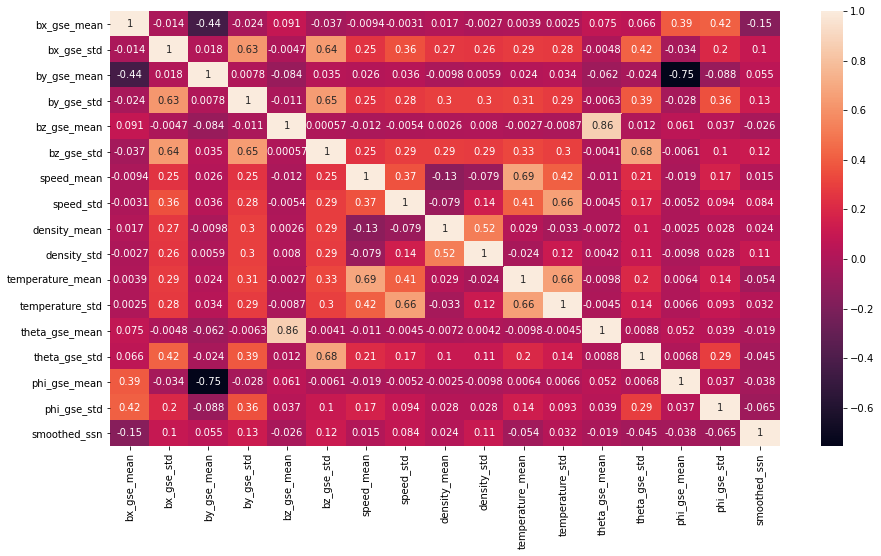

In [9]:
import seaborn as sns
a=features.corr()
plt.figure(figsize=[15,8])
sns.heatmap(a,annot=True)

In [10]:
# check to make sure missing values are filled
assert (features.isna().sum() == 0).all()

In [11]:
YCOLS = ["t0", "t1"]


def process_labels(dst):
    y = dst.copy()
    y["t1"] = y.groupby("period").dst.shift(-1)
    y.columns = YCOLS
    return y


labels = process_labels(dst)
labels.head()

t0    t1
period  timedelta                
train_a 0 days 00:00:00  -7 -10.0
        0 days 01:00:00 -10 -10.0
        0 days 02:00:00 -10  -6.0
        0 days 03:00:00  -6  -2.0
        0 days 04:00:00  -2   3.0

In [12]:
data = labels.join(features)
data.head()

t0    t1  bx_gse_mean  bx_gse_std  by_gse_mean  \
period  timedelta                                                         
train_a 0 days 00:00:00  -7 -10.0    -1.599207   -0.381502     0.419516   
        0 days 01:00:00 -10 -10.0    -1.757995   -0.867747     0.179257   
        0 days 02:00:00 -10  -6.0    -1.912116   -1.114317     0.183266   
        0 days 03:00:00  -6  -2.0    -1.809045   -0.783042    -0.378111   
        0 days 04:00:00  -2   3.0    -1.338802   -0.484910     0.072745   

                         by_gse_std  bz_gse_mean  bz_gse_std  speed_mean  \
period  timedelta                                                          
train_a 0 days 00:00:00    0.031658     0.300358   -0.651645   -0.738546   
        0 days 01:00:00   -0.272971     0.446103   -0.517913   -0.986904   
        0 days 02:00:00   -0.822786     0.770174   -0.876490   -1.013548   
        0 days 03:00:00    0.341156     0.621194   -0.290211   -0.826469   
        0 days 04:00:00    1.023019     0.467629   -0.478080   -0.601238   

                         speed_std  density_mean  density_std  \
period  timedelta                                               
train_a 0 days 00:00:00   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   0.554085     -0.846222    -0.220012   
        0 days 03:00:00  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   1.016033     -0.371487     0.097253   

                         temperature_mean  temperature_std  theta_gse_mean  \
period  timedelta                                                            
train_a 0 days 00:00:00         -0.375267         0.383941        0.262090   
        0 days 01:00:00         -0.479430         0.953178        0.378546   
        0 days 02:00:00         -0.574831        -0.192518        0.607449   
        0 days 03:00:00         -0.324709         0.325491        0.491460   
        0 days 04:00:00         -0.313432         0.201600        0.466528   

                         theta_gse_std  phi_gse_mean  phi_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00      -1.146417     -0.364011    -0.705389   
        0 days 01:00:00      -1.054098     -0.251802    -0.737261   
        0 days 02:00:00      -1.394479     -0.250240    -0.854941   
        0 days 03:00:00      -0.903670     -0.047015    -0.621963   
        0 days 04:00:00      -0.906983     -0.234798    -0.368182   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

<AxesSubplot:>

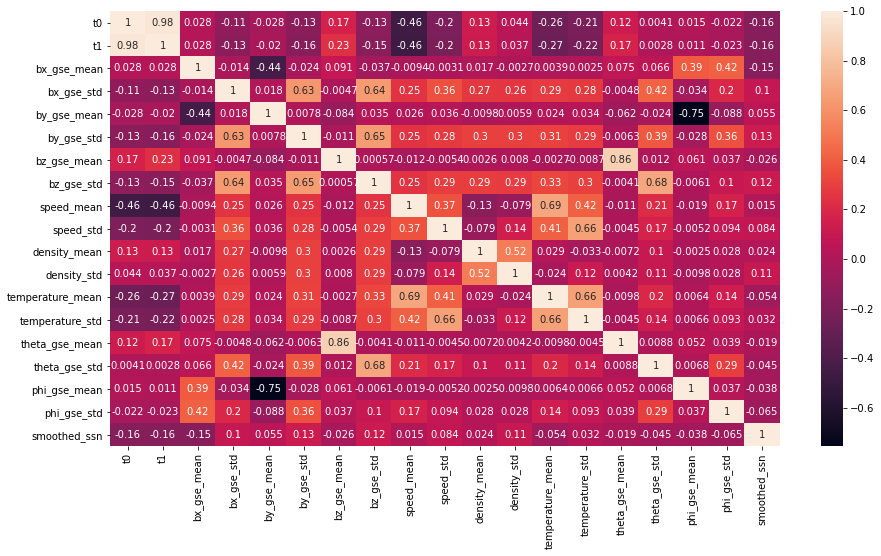

In [13]:
import seaborn as sns
ab=data.corr()
plt.figure(figsize=[15,8])
sns.heatmap(ab,annot=True)

In [14]:
data.columns

Index(['t0', 't1', 'bx_gse_mean', 'bx_gse_std', 'by_gse_mean', 'by_gse_std',
       'bz_gse_mean', 'bz_gse_std', 'speed_mean', 'speed_std', 'density_mean',
       'density_std', 'temperature_mean', 'temperature_std', 'theta_gse_mean',
       'theta_gse_std', 'phi_gse_mean', 'phi_gse_std', 'smoothed_ssn'],
      dtype='object')

In [15]:
data=data[['t0', 't1','bx_gse_std', 'by_gse_std',
       'bz_gse_mean', 'bz_gse_std', 'speed_mean', 'speed_std', 'density_mean',
       'temperature_mean', 'temperature_std', 'theta_gse_mean',
        'smoothed_ssn']]

In [16]:
def get_train_test_val(data, test_per_period, val_per_period):
    """Splits data across periods into train, test, and validation"""
    # assign the last `test_per_period` rows from each period to test
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    # assign the last `val_per_period` from the remaining rows to validation
    val = interim.groupby("period").tail(val_per_period)
    # the remaining rows are assigned to train
    train = interim[~interim.index.isin(val.index)]
    return train, test, val


train, test, val = get_train_test_val(data, test_per_period=6_000, val_per_period=6_000)


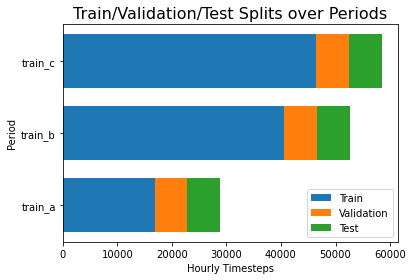

In [17]:
ind = [0, 1, 2]
names = ["train_a", "train_b", "train_c"]
width = 0.75
train_cnts = [len(df) for _, df in train.groupby("period")]
val_cnts = [len(df) for _, df in val.groupby("period")]
test_cnts = [len(df) for _, df in test.groupby("period")]

p1 = plt.barh(ind, train_cnts, width)
p2 = plt.barh(ind, val_cnts, width, left=train_cnts)
p3 = plt.barh(ind, test_cnts, width, left=np.add(val_cnts, train_cnts).tolist())

plt.yticks(ind, names)
plt.ylabel("Period")
plt.xlabel("Hourly Timesteps")
plt.title("Train/Validation/Test Splits over Periods", fontsize=16)
plt.legend(["Train", "Validation", "Test"])

In [18]:
#Keeping only the columns I want to input
XCOLS=data.columns
XCOLS

Index(['t0', 't1', 'bx_gse_std', 'by_gse_std', 'bz_gse_mean', 'bz_gse_std',
       'speed_mean', 'speed_std', 'density_mean', 'temperature_mean',
       'temperature_std', 'theta_gse_mean', 'smoothed_ssn'],
      dtype='object')

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [20]:
data_config = {
    "timesteps": 16,
    "batch_size":32,
}


def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset


train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of val batches: {len(val_ds)}")

Number of train batches: 3245
Number of val batches: 561


### Model with lowest RMSE as of now = 13.78 in Google Drive

In [21]:
# define our model
from tensorflow.keras.layers import Dropout
model_config = {"n_epochs": 100, "n_neurons": 128,
                  "dropout": 0.4, "stateful": False}

def models():
  
  model = Sequential()
  model.add(
      LSTM(
          model_config["n_neurons"],
          # usually set to (`batch_size`, `sequence_length`, `n_features`)
          # setting the batch size to None allows for variable length batches
          batch_input_shape=(None, data_config["timesteps"], len(XCOLS)),
          stateful=model_config["stateful"],
          dropout=model_config["dropout"],
          activation='relu',kernel_regularizer='l2',
      )
  )
 
  model.add(Dense(32,kernel_regularizer='l2'))
  model.add(Dropout(0.4))
  model.add(Dense(32,kernel_regularizer='l2'))
  model.add(Dropout(0.4))
  #model.add(Dense())
  model.add(Dense(len(YCOLS)))
  opt=Adam(learning_rate=0.00001)
  model.compile(
      loss="mean_squared_error",
      optimizer=opt,
  )
  return model

In [22]:
model_final=models()
model_final.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               72704     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 77,954
Trainable params: 77,954
Non-trainable params: 0
____________________________________________________

In [23]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history_final = model_final.fit(
    train_ds,
    batch_size=data_config["batch_size"],
    epochs=model_config["n_epochs"],
    verbose=1,
    shuffle=False,
    validation_data=val_ds,
    callbacks=[es]
)

Epoch 1/100
3245/3245 [==============================] - 40s 12ms/step - loss: 491.1461 - val_loss: 167.8807
Epoch 2/100
3245/3245 [==============================] - 38s 12ms/step - loss: 247.8997 - val_loss: 122.0366
Epoch 3/100
3245/3245 [==============================] - 39s 12ms/step - loss: 201.3955 - val_loss: 110.8699
Epoch 4/100
3245/3245 [==============================] - 38s 12ms/step - loss: 166.8223 - val_loss: 111.3683
Epoch 5/100
3245/3245 [==============================] - 37s 11ms/step - loss: 144.5072 - val_loss: 104.0616
Epoch 6/100
3245/3245 [==============================] - 37s 11ms/step - loss: 131.4563 - val_loss: 102.3930
Epoch 7/100
3245/3245 [==============================] - 37s 11ms/step - loss: 119.3231 - val_loss: 105.6712
Epoch 8/100
3245/3245 [==============================] - 37s 11ms/step - loss: 111.0831 - val_loss: 103.1152
Epoch 9/100
3245/3245 [==============================] - 39s 12ms/step - loss: 103.4272 - val_loss: 98.4287
Epoch 10/100
3245/32

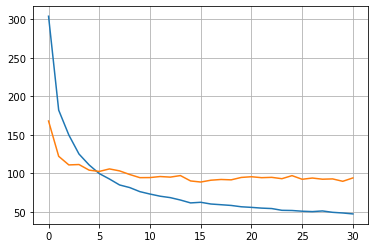

In [24]:
for name, values in history_final.history.items():
    plt.plot(values)
    plt.grid("True")

In [25]:
test_ds = timeseries_dataset_from_df(test, data_config["batch_size"])
mse = model_final.evaluate(test_ds)
print(f"Test RMSE: {mse**.5:.4f}")

561/561 [==============================] - 3s 6ms/step - loss: 101.2362
Test RMSE: 10.0616


## Run with lower LSTM Layers , 32 Neurons

In [26]:
# define our model
from tensorflow.keras.layers import Dropout
model_config = {"n_epochs": 100, "n_neurons": 32,
                  "dropout": 0.4, "stateful": False}

def models():
  
  model = Sequential()
  model.add(
      LSTM(
          model_config["n_neurons"],
          # usually set to (`batch_size`, `sequence_length`, `n_features`)
          # setting the batch size to None allows for variable length batches
          batch_input_shape=(None, data_config["timesteps"], len(XCOLS)),
          stateful=model_config["stateful"],
          dropout=model_config["dropout"],
          activation='relu',kernel_regularizer='l2',
      )
  )
 
  model.add(Dense(32,kernel_regularizer='l2'))
  model.add(Dropout(0.4))
  model.add(Dense(32,kernel_regularizer='l2'))
  model.add(Dropout(0.4))
  #model.add(Dense())
  model.add(Dense(len(YCOLS)))
  opt=Adam(learning_rate=0.00001)
  model.compile(
      loss="mean_squared_error",
      optimizer=opt,
  )
  return model

In [27]:
model_final2=models()
model_final2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5888      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 8,066
Trainable params: 8,066
Non-trainable params: 0
____________________________________________________

In [28]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history_final2 = model_final2.fit(
    train_ds,
    batch_size=data_config["batch_size"],
    epochs=model_config["n_epochs"],
    verbose=1,
    shuffle=False,
    validation_data=val_ds,
    callbacks=[es]
)

Epoch 1/100
3245/3245 [==============================] - 25s 7ms/step - loss: 697.3697 - val_loss: 302.3349
Epoch 2/100
3245/3245 [==============================] - 24s 7ms/step - loss: 573.2931 - val_loss: 263.4425
Epoch 3/100
3245/3245 [==============================] - 25s 8ms/step - loss: 487.6907 - val_loss: 233.4111
Epoch 4/100
3245/3245 [==============================] - 25s 8ms/step - loss: 436.2651 - val_loss: 207.3859
Epoch 5/100
3245/3245 [==============================] - 23s 7ms/step - loss: 391.3705 - val_loss: 183.7304
Epoch 6/100
3245/3245 [==============================] - 24s 7ms/step - loss: 343.0373 - val_loss: 166.9801
Epoch 7/100
3245/3245 [==============================] - 25s 8ms/step - loss: 314.4366 - val_loss: 154.3068
Epoch 8/100
3245/3245 [==============================] - 25s 8ms/step - loss: 304.7864 - val_loss: 146.3505
Epoch 9/100
3245/3245 [==============================] - 25s 8ms/step - loss: 283.0154 - val_loss: 140.7352
Epoch 10/100
3245/3245 [====

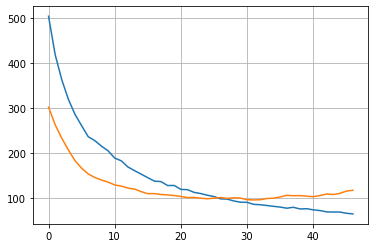

In [29]:
for name, values in history_final2.history.items():
    plt.plot(values)
    plt.grid("True")

In [30]:
test_ds = timeseries_dataset_from_df(test, data_config["batch_size"])
mse = model_final2.evaluate(test_ds)
print(f"Test RMSE: {mse**.5:.4f}")

561/561 [==============================] - 2s 3ms/step - loss: 131.1149
Test RMSE: 11.4505


In [31]:
# import json
# import pickle

# model.save("model")

# with open("scaler.pck", "wb") as f:
#     pickle.dump(scaler, f)

# data_config["solar_wind_subset"] = SOLAR_WIND_FEATURES
# print(data_config)
# with open("config.json", "w") as f:
#     json.dump(data_config, f)